# Engineering of Data Analysis: assignment 1

By delivering this notebook, we confirm that the code presented was developed by the following students.

**Student num:** **; Name:**

**Student num:** **; Name:**

**DEADLINE:** 21st April, 23h59

**Only one student should deliver the notebook**


**IMPORTANT:** To use GPUs in Colab, you need to go to the menu ```Edit > Notebook settings``` and select GPU as the hardware accelerator.

Some useful links:
* [ACM DEBS 2015 Grand Challenge](http://www.debs2015.org/call-grand-challenge.html)

* [Spark web site](https://spark.apache.org/)

* [Spark MLlib main page](https://spark.apache.org/mllib/)
* [Spark MLlib guide](https://spark.apache.org/docs/latest/ml-guide.html)

* [CuDF documentation](https://docs.rapids.ai/api/cudf/stable/)
* [cuML documentation](https://docs.rapids.ai/api/cuml/stable/)


# Install software

In [ ]:
# Software to download files
!pip install gdown

In [1]:
# Install Spark
!apt-get install openjdk-17-jdk-headless
!pip install pyspark==4.0.0.dev2
!mkdir checkpoint

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  openjdk-17-jre-headless
Suggested packages:
  openjdk-17-demo openjdk-17-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-17-jdk-headless openjdk-17-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 120 MB of archives.
After this operation, 271 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jre-headless amd64 17.0.14+7-1~22.04.1 [48.3 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 openjdk-17-jdk-headless amd64 17.0.14+7-1~22.04.1 [71.3 MB]
Fetched 120 MB in 3s (36.4 MB/s)
Selecting previously unselected package openjdk-17-jre-headless:amd64.
(Reading database ...

In [5]:
# Install RAPIDS - for using cuDF, cuML
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible,
# it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 592 (delta 125), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (592/592), 194.79 KiB | 16.23 MiB/s, done.
Resolving deltas: 100% (299/299), done.
Installing RAPIDS remaining 25.04 libraries
Using Python 3.11.12 environment at: /usr
Resolved 173 packages in 11.69s
 Downloaded cuproj-cu12
 Downloaded shapely
 Downloaded datashader
 Downloaded cudf-cu12
 Downloaded dask
 Downloaded pylibcugraph-cu12
 Downloaded ucx-py-cu12
 Downloaded rmm-cu12
 Downloaded libkvikio-cu12
 Downloaded cuspatial-cu12
 Downloaded librmm-cu12
 Downloaded cugraph-cu12
 Downloaded cucim-cu12
 Downloaded cuml-cu12
 Downloaded libcuspatial-cu12
 Downloaded pylibcudf-cu12
 Downloaded libraft-cu12
 Downloaded raft-dask-cu12
 Downloaded libcudf-cu12
 Downloaded libcuml-cu12
 Downloaded libcuvs-cu12
 Downloade

# Setup

The data sets are available in the following link: https://drive.google.com/drive/folders/1WMwLUj0t4Q0GSll96lbF2bDjaPVh1w8z?usp=sharing. For running in Google Colab, you should access the link and Add Shortcut to your Drive.



In [2]:
#Limit memory usage, to avoid crashing the system and needing to rerun all cells
import psutil, resource

def set_percentage_memory_limit(percent):
    total = psutil.virtual_memory().total
    limit = total * percent // 100
    soft, hard = resource.getrlimit(resource.RLIMIT_AS)
    resource.setrlimit(resource.RLIMIT_AS, (limit, hard))

# Max 95 % RAM usage allowed
set_percentage_memory_limit(95)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# If you added the shortcut to your drive, the file should appear in this directory
# If not, you need to explore from directory /content/drive
!ls /content/drive/MyDrive/Engineering_of_Data_Analysis/assignment1

Mounted at /content/drive
sample.csv.gz  sorted_data.csv.gz  tiny.csv.gz


Next cells setup: Pandas, Spark and cuDF/cuML.

In [4]:
# General imports
import timeit

import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster

In [5]:
# Imports for Spark

import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

# imports Spark SQL and Pandas API
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import *
from pyspark.ml.feature import *
import pyspark.pandas as ps

# this sets the maximum number of rows to show when printing pyspark pandas Dataframes
ps.set_option('display.max_rows', 10)

/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: The config 'spark.sql.ansi.enabled' is set to True. This can cause unexpected behavior from pandas API on Spark since pandas API on Spark follows the behavior of pandas, not SQL.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [6]:
# Imports for cuDF / cuML
import cudf
import cupy as cp
import cuml.cluster

# Other Imports
import matplotlib.pyplot as plt
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.linalg import Vectors

In [6]:
# Setup the dataset being used

# Large dataset - 12.3 GB compressed
Large_dataset = "/content/drive/MyDrive/Engineering_of_Data_Analysis/assignment1/sorted_data.csv.gz"

# Small dataset - 135 MB compressed
Small_dataset = "/content/drive/MyDrive/Engineering_of_Data_Analysis/assignment1/sample.csv.gz"

# Tiny dataset - 6.8 MB compressed (you can use this one for speeding up development only)
Tiny_dataset = "/content/drive/MyDrive/Engineering_of_Data_Analysis/assignment1/tiny.csv.gz"

## Simple statistics

We will print some simple statistics.

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Assignment 1") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

start_time = time.time()

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(Tiny_dataset, format="csv",
                         sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")

statistics = spark.sql( """SELECT COUNT( DISTINCT medallion) AS num_medallion,
                                  COUNT( DISTINCT hack_license) AS num_license,
                                  MIN( pickup_datetime) AS min_pickup,
                                  MAX( dropoff_datetime) AS max_dropoff,
                                  MAX( trip_time_in_secs) AS max_trip_time,
                                  MAX( trip_distance) AS max_trip_distance,
                                  MAX( total_amount) AS max_total_amount
                                  FROM data""")
statistics.show()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


+-------------+-----------+-------------------+-------------------+-------------+-----------------+----------------+
|num_medallion|num_license|         min_pickup|        max_dropoff|max_trip_time|max_trip_distance|max_total_amount|
+-------------+-----------+-------------------+-------------------+-------------+-----------------+----------------+
|         6467|       9614|2013-01-01 00:00:00|2013-01-01 12:22:00|        10800|            50.47|          321.05|
+-------------+-----------+-------------------+-------------------+-------------+-----------------+----------------+

Runtime = 12.593300104141235


## Ploting information

Example on how to plot information using matplotlib.

### First plot

This first plot helps showing that data has several invalid values.

Let's plot the pickups.

Plotting pickups


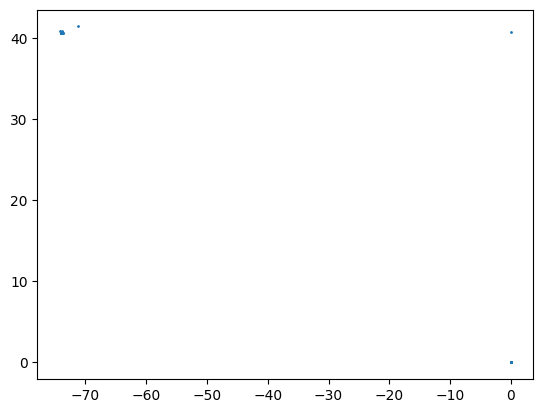

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(Small_dataset, format="csv",
                         sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")

# Plotting all points is probably too much in many computers, so lets plot only a few 1000's
data = spark.sql( "SELECT * FROM data LIMIT 1000")
pickups = data.collect()

print('Plotting pickups')
plt.scatter([row.pickup_longitude for row in pickups],
            [row.pickup_latitude for row in pickups],
            s=1)
plt.show()

### Plotting heatamps

This example shows how to **plot heatmaps** and how to **create a grid** with coordinates -- note that we need to group nearby coordinates together or (almost) every coordinate will be unique.

The example creates a grid, with cell of 150m of side (commented out the code for cells of 500m of side).

\[From ACM DEBS 2015 Grand Challenge page\]

**Question 1**: Is the earth flat or how to map coordinates to cells?

**Answer**: For the challenge we allow a simplified flat earth assumption for mapping coordinates to cells in the queries. You can assume that a distance of 500 meter south corresponds to a change of 0.004491556 degrees in the coordinate system. For moving 500 meter east you can assume a change of 0.005986 degrees in the coordinate system.

Plotting frequency pickups


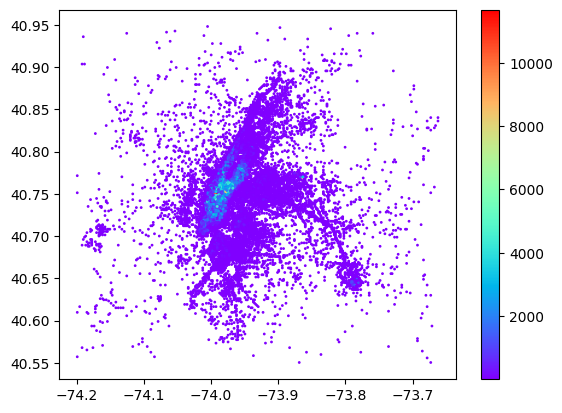

Plotting frequency dropoffs


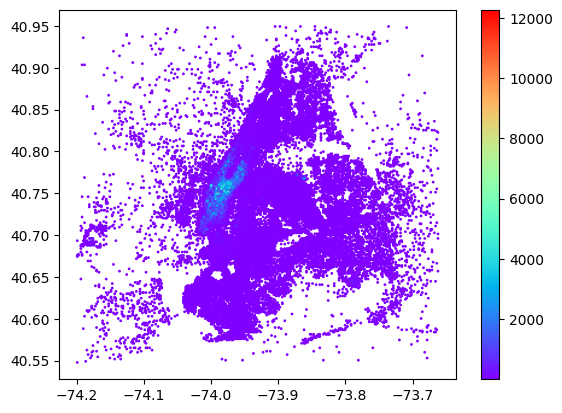

In [ ]:
# Squares of 500 meters
#latitudeStep = 0.004491556
#longitudeStep = 0.005986
#northLatitude = 41.474937 - 0.5 * latitudeStep
#southLatitude = northLatitude - 300 * latitudeStep
#westLongitude = -74.913585 - 0.5 * longitudeStep
#eastLongitude = westLongitude + 300 * longitudeStep

# Squares of 150 meters
latitudeStep = 0.0013474668
longitudeStep = 0.0017958
northLatitude = 40.95
southLatitude = northLatitude - 300 * latitudeStep
westLongitude = -74.2
eastLongitude = westLongitude + 300 * longitudeStep

# function to round longitude to a point in the middle of the square
def longRound( val):
    return ((val - westLongitude) // longitudeStep) * longitudeStep + westLongitude + longitudeStep / 2
spark.udf.register("longround", longRound, DoubleType())

# function to round latitude to a point in the middle of the square
def latRound( l):
    return northLatitude - ((northLatitude - l) // latitudeStep) * latitudeStep - latitudeStep / 2
spark.udf.register("latround", latRound, DoubleType())

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(Small_dataset, format="csv",
                         sep=",", schema=mySchema, header="false")

# Let's filter data outside of the box and build a grid
# Points in each square are mapped to the center of the square.
dataset.createOrReplaceTempView("data")
filteredDataDF = spark.sql( """SELECT medallion, hack_license, pickup_datetime,
                                    dropoff_datetime, trip_time_in_secs, trip_distance,
                                    longround(pickup_longitude) AS pickup_longitude,
                                    latround(pickup_latitude) AS pickup_latitude,
                                    longround(dropoff_longitude) AS dropoff_longitude,
                                    latround(dropoff_latitude) AS dropoff_latitude,
                                    payment_type, fare_amount, mta_tax,
                                    tip_amount, tolls_amount, total_amount
                                  FROM data
                                  WHERE pickup_longitude >= """ + str(westLongitude) + """ AND
                                  pickup_longitude <=  """ + str(eastLongitude) + """ AND
                                  dropoff_longitude >=  """ + str(westLongitude) + """ AND
                                  dropoff_longitude <=  """ + str(eastLongitude) + """ AND
                                  pickup_latitude <= """ + str(northLatitude) + """ AND
                                  pickup_latitude >= """ + str(southLatitude) + """ AND
                                  dropoff_latitude <=  """ + str(northLatitude) + """ AND
                                  dropoff_latitude >=  """ + str(southLatitude))
filteredDataDF.createOrReplaceTempView("data")

# Frequency for pickups
pickupsDF = spark.sql( """SELECT pickup_longitude, pickup_latitude, count(*) AS cnt
                                  FROM data
                                  GROUP BY pickup_longitude, pickup_latitude""")
pickups = pickupsDF.collect()

print('Plotting frequency pickups')
p = plt.scatter([row.pickup_longitude for row in pickups],
            [row.pickup_latitude for row in pickups],
            c=[row.cnt for row in pickups],s=1,cmap="rainbow")
plt.colorbar(p)
plt.show()

# Frequency for dropoffs
dropoffsDF = spark.sql( """SELECT dropoff_longitude, dropoff_latitude, count(*) AS cnt
                                  FROM data
                                  GROUP BY dropoff_longitude, dropoff_latitude""")
dropoffs = dropoffsDF.collect()

print('Plotting frequency dropoffs')
p = plt.scatter([row.dropoff_longitude for row in dropoffs],
            [row.dropoff_latitude for row in dropoffs],
            c=[row.cnt for row in dropoffs],s=1,cmap="rainbow")
plt.colorbar(p)
plt.show()


## Exercise 1: simple statistics

Compute, for each license, the total amount of money collected.

Comapre the time it takes to execute the code for Pandas, Spark Pandas API, Spark SQL and cuDF.

**Draw some conclusions** by comparing the time for performing the computation using Spark and Pandas, and also when using the small and long dataset.

### Code: Pandas library

In [ ]:
start_time_small_pandas = time.time()
mySchema = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount",
            "surcharge", "mta_tax", "tip_amount",
            "tolls_amount", "total_amount"]

dataset_small = pd.read_csv(Small_dataset,names=mySchema)
result_small = dataset_small[["hack_license","total_amount"]].groupby("hack_license").sum()

end_time_small_pandas = time.time()

print( "Runtime Small Dataset = " + str(end_time_small_pandas - start_time_small_pandas))

Runtime Small Dataset = 10.732520341873169


In [ ]:
start_time_large_pandas = time.time()
mySchema = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount",
            "surcharge", "mta_tax", "tip_amount",
            "tolls_amount", "total_amount"]

dataset_large_pandas = pd.read_csv(Large_dataset,names=mySchema)
result_large = dataset_large_pandas[["hack_license","total_amount"]].groupby("hack_license").sum()

end_time_large_pandas = time.time()

print( "Runtime Large Dataset= " + str(end_time_large_pandas - start_time_large_pandas))

MemoryError: Unable to allocate 256. KiB for an array with shape (32768,) and data type int64

### Results (Pandas)

The time to process the small dataset was : **10.732520341873169** seconds.

The time to process the large dataset was : **"MemoryError: Unable to allocate 256. KiB for an array with shape (32768,) and data type int64
"**

### Code: Spark Pandas API

In [ ]:
import time
import pandas as pd

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Assignment 1") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

# Clear Spark Cache so datasets are loaded from scratch
spark.catalog.clearCache()

start_time_small_spark = time.time()
mySchema = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount",
            "surcharge", "mta_tax", "tip_amount",
            "tolls_amount", "total_amount"]

dataset_small_pandas = ps.read_csv(Small_dataset,names=mySchema)
result_small = dataset_small_pandas[["hack_license","total_amount"]].groupby("hack_license").sum()

# force execution
result0 = result_small.to_spark().collect()

end_time_small_spark = time.time()

print( "Runtime Small Dataset= " + str(end_time_small_spark - start_time_small_spark))

/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Runtime Small Dataset= 28.40843439102173


In [ ]:
# Clear Spark Cache so datasets are loaded from scratch
spark.catalog.clearCache()

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Assignment 1") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

start_time_large_spark = time.time()
mySchema = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount",
            "surcharge", "mta_tax", "tip_amount",
            "tolls_amount", "total_amount"]

dataset_large_pandas = ps.read_csv(Large_dataset,names=mySchema)
result_large = dataset_large_pandas[["hack_license","total_amount"]].groupby("hack_license").sum()

# force execution
result1 = result_large.to_spark().collect()

end_time_large_spark = time.time()

print( "Runtime Large Dataset= " + str(end_time_large_spark - start_time_large_spark))

/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: The config 'spark.sql.ansi.enabled' is set to True. This can cause unexpected behavior from pandas API on Spark since pandas API on Spark follows the behavior of pandas, not SQL.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Runtime Large Dataset= 1588.1552798748016


### Results (Spark Pandas API)

The time to process the small dataset was : **28.40843439102173** seconds.

The time to process the large dataset was : **1588.1552798748016** seconds.

### Spark SQL

In [ ]:
# Note, runtime needs to be restarted before running these cells if the Spark
# Pandas API cells have already been run before because otherwise Spark SQL
# will load the datasets from memory, which means the times to process the
# datasets are no longer comparable

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

# Clear Spark Cache so datasets are loaded from scratch
spark.catalog.clearCache()

start_time_small_sql = time.time()

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])
dataset_small_sql = spark.read.load(Small_dataset, format="csv",
                         sep=",", schema=mySchema, header="false")
dataset_small_sql.createOrReplaceTempView("data")
statisticsDF = spark.sql( """SELECT hack_license, SUM(total_amount) AS total_amount FROM data GROUP BY hack_license""")
statistics = statisticsDF.collect()

end_time_small_sql = time.time()

print( "Runtime = " + str(end_time_small_sql - start_time_small_sql))

Runtime = 12.791284084320068


In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

# Clear Spark Cache so datasets are loaded from scratch
spark.catalog.clearCache()

start_time_large_sql = time.time()

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])




dataset_large_sql = spark.read.load(Large_dataset, format="csv",
                         sep=",", schema=mySchema, header="false")
dataset_large_sql.createOrReplaceTempView("data")
statisticsDF = spark.sql( """SELECT hack_license, SUM(total_amount) AS total_amount FROM data GROUP BY hack_license""")
statistics = statisticsDF.collect()

end_time_large_sql = time.time()

print( "Runtime = " + str(end_time_large_sql - start_time_large_sql))

Runtime = 630.4246764183044


### Results (Spark)

The time to process the small dataset was : **12.791284084320068** seconds.

The time to process the large dataset was : **630.4246764183044** seconds.

### Code: cuDF

In [8]:
# Verify we have access to a CUDA-capable GPU to use CuDF
!nvidia-smi

Sun Apr 20 17:18:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
# Set and validate that CuDF can use the CUDA-capable GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # Gives CuDF access to Google Colab GPU
print(os.environ.get('CUDA_VISIBLE_DEVICES'))

0


In [ ]:
start_time_small_cuDF = time.time()

mySchema = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount",
            "surcharge", "mta_tax", "tip_amount",
            "tolls_amount", "total_amount"]

dataset_small_cuDF = cudf.read_csv(Small_dataset,names=mySchema)
result_small_cuDF = dataset_small_cuDF[["hack_license","total_amount"]].groupby("hack_license").sum()

end_time_small_cuDF = time.time()

print( "Runtime = " + str(end_time_small_cuDF - start_time_small_cuDF))

Runtime = 2.5713372230529785


In [ ]:
start_time_large_cuDF = time.time()
mySchema = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount",
            "surcharge", "mta_tax", "tip_amount",
            "tolls_amount", "total_amount"]

dataset_large_cuDF = cudf.read_csv(Large_dataset,names=mySchema)
result_large_cuDF = dataset_large_cuDF[["hack_license","total_amount"]].groupby("hack_license").sum()

end_time_large_cuDF = time.time()

print( "Runtime = " + str(end_time_large_cuDF - start_time_large_cuDF))

RuntimeError: CUDF failure at: /__w/cudf/cudf/cpp/src/io/comp/uncomp.cpp:295: ZLIB decompression failed

In [ ]:
# The large dataset gives a RuntimeError
# To find out why this is, manually decompress the file and then check
# if it works that way

# Define the input file path (requires READ access only)
GZ_FILE="/content/drive/MyDrive/Engineering_of_Data_Analysis/assignment1/sorted_data.csv.gz"

# Define the output file path in your LOCAL, WRITABLE /content/ directory
DECOMPRESSED_FILE="/content/sorted_data_decompressed.csv"

print(f"Reading from: {GZ_FILE}")
print(f"Writing decompressed output to: {DECOMPRESSED_FILE} (in local session storage)")

# Reading from GZ_FILE and writing to DECOMPRESSED_FILE
!gzip -dkc "$GZ_FILE" > "$DECOMPRESSED_FILE"

print("\nChecking local decompressed file:")
!ls -lh "$DECOMPRESSED_FILE"

Reading from: /content/drive/MyDrive/Engineering_of_Data_Analysis/assignment1/sorted_data.csv.gz
Writing decompressed output to: /content/sorted_data_decompressed.csv (in local session storage)

Checking local decompressed file:
-rw-r--r-- 1 root root 32G Apr 18 18:03 /content/sorted_data_decompressed.csv


In [ ]:
# running again with decompressed version

start_time_large_cuDF = time.time()
mySchema = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount",
            "surcharge", "mta_tax", "tip_amount",
            "tolls_amount", "total_amount"]

dataset_large_cuDF = cudf.read_csv(DECOMPRESSED_FILE,names=mySchema)
result_large_cuDF = dataset_large_cuDF[["hack_license","total_amount"]].groupby("hack_license").sum()

end_time_large_cuDF = time.time()

print( "Runtime = " + str(end_time_large_cuDF - start_time_large_cuDF))

MemoryError: std::bad_alloc: out_of_memory: CUDA error (failed to allocate 33295450768 bytes) at: /pyenv/versions/3.12.9/lib/python3.12/site-packages/librmm/include/rmm/mr/device/cuda_memory_resource.hpp:62: cudaErrorMemoryAllocation out of memory

### Results (cuDF)

The time to process the small dataset was : **2.5713372230529785** seconds.

The time to process the large dataset was : **MemoryError: std::bad_alloc: out_of_memory: CUDA error (failed to allocate 33295450768 bytes) at: /pyenv/versions/3.12.9/lib/python3.12/site-packages/librmm/include/rmm/mr/device/cuda_memory_resource.hpp:62: cudaErrorMemoryAllocation out of memory** seconds.

### Discussion of results

**Performance Comparison**:
- **Small Dataset (135 MB compressed)**:
  - **cuDF**: Fastest at 2.57s, leveraging GPU acceleration for efficient grouping and summation.
  - **Pandas**: 10.73s, competitive due to in-memory processing but slower than cuDF.
  - **Spark SQL**: 12.79s, slower due to distributed overhead (e.g., JVM setup, task scheduling).
  - **Spark Pandas API**: Slowest at 35.83s, burdened by both Spark’s overhead and Pandas abstraction.
- **Large Dataset (12.3 GB compressed)**:
  - **Spark SQL**: 630.42s, most efficient for large-scale data with distributed processing.
  - **Spark Pandas API**: 1761.67s, functional but slower due to API overhead.
  - **Pandas**: Failed (MemoryError), unable to handle large data due to memory constraints.
  - **cuDF**: Failed (ZLIB decompression error), due to GPU memory limitations. The uncompressed dataset is 33GB large. This is more than the GPU RAM in the Colab instance (only 15GB). Therefore, the dataset can't be loaded in.

**Suitability Analysis**:
- **cuDF**: Ideal for small to medium datasets with GPU support, offering the fastest performance (2.57s for small). Unsuitable for very large datasets if GPU memory is insufficient, as seen in the failure.
- **Pandas**: Suitable for small datasets (10.73s) due to simplicity and low overhead, but impractical for large datasets due to memory limitations.
- **Spark SQL**: Best for large datasets (630.42s), balancing scalability and performance. Less efficient for small datasets due to overhead.
- **Spark Pandas API**: Least suitable, with high overhead (35.83s small, 1761.67s large) and no significant advantages over Spark SQL, despite familiar syntax.

**Conclusion**: cuDF is optimal for small datasets with GPU access, while Spark SQL is the most reliable for large datasets. Pandas is limited to small-scale tasks, and Spark Pandas API is generally outperformed by Spark SQL.

## Exercise 2

The code presented in the **Plotting heatmap** section includes the call to an registered Python UDF function. In this exercise we want to measure the impact of using the UDF function.

Run this exercise with the small dataset.

### Code: with UDF function

In [7]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Assignment 1") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

start_time = time.time()
# Squares of 150 meters
latitudeStep = 0.0013474668
longitudeStep = 0.0017958
northLatitude = 40.95
southLatitude = northLatitude - 300 * latitudeStep
westLongitude = -74.2
eastLongitude = westLongitude + 300 * longitudeStep

# function to round longitude to a point in the middle of the square
def longRound( val):
    return ((val - westLongitude) // longitudeStep) * longitudeStep + westLongitude + longitudeStep / 2
spark.udf.register("longround", longRound, DoubleType())

# function to round latitude to a point in the middle of the square
def latRound( l):
    return northLatitude - ((northLatitude - l) // latitudeStep) * latitudeStep - latitudeStep / 2
spark.udf.register("latround", latRound, DoubleType())

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(Small_dataset, format="csv",
                         sep=",", schema=mySchema, header="false")

# Let's filter data outside of the box and build a grid
# Points in each square are mapped to the center of the square.
dataset.createOrReplaceTempView("data")
filteredDataDF = spark.sql( """SELECT medallion, hack_license, pickup_datetime,
                                    dropoff_datetime, trip_time_in_secs, trip_distance,
                                    longround(pickup_longitude) AS pickup_longitude,
                                    latround(pickup_latitude) AS pickup_latitude,
                                    longround(dropoff_longitude) AS dropoff_longitude,
                                    latround(dropoff_latitude) AS dropoff_latitude,
                                    payment_type, fare_amount, mta_tax,
                                    tip_amount, tolls_amount, total_amount
                                  FROM data
                                  WHERE pickup_longitude >= """ + str(westLongitude) + """ AND
                                  pickup_longitude <=  """ + str(eastLongitude) + """ AND
                                  dropoff_longitude >=  """ + str(westLongitude) + """ AND
                                  dropoff_longitude <=  """ + str(eastLongitude) + """ AND
                                  pickup_latitude <= """ + str(northLatitude) + """ AND
                                  pickup_latitude >= """ + str(southLatitude) + """ AND
                                  dropoff_latitude <=  """ + str(northLatitude) + """ AND
                                  dropoff_latitude >=  """ + str(southLatitude))
filteredDataDF.createOrReplaceTempView("data")

# Frequency for pickups
pickupsDF = spark.sql( """SELECT pickup_longitude, pickup_latitude, count(*) AS cnt
                                  FROM data
                                  GROUP BY pickup_longitude, pickup_latitude""")
pickups = pickupsDF.collect()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


Runtime = 39.631415605545044


 ### Results (Spark SQL with UDF Python function)

The time to process the small dataset was : **39.631415605545044** seconds.

### Code: without UDF function

Write the code in Spark SQL without using the auxiliary function.

In [7]:
# TO COMPLETE
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Assignment 1") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

start_time = time.time()
# Squares of 150 meters
latitudeStep = 0.0013474668
longitudeStep = 0.0017958
northLatitude = 40.95
southLatitude = northLatitude - 300 * latitudeStep
westLongitude = -74.2
eastLongitude = westLongitude + 300 * longitudeStep

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(Small_dataset, format="csv",
                         sep=",", schema=mySchema, header="false")

# Let's filter data outside of the box and build a grid
# Points in each square are mapped to the center of the square.
dataset.createOrReplaceTempView("data")
filteredDataDF = spark.sql(f"""SELECT medallion, hack_license, pickup_datetime,
                                dropoff_datetime, trip_time_in_secs, trip_distance,
                                (FLOOR((pickup_longitude - {westLongitude}) / {longitudeStep}) * {longitudeStep} + {westLongitude} + ({longitudeStep} / 2)) AS pickup_longitude,
                                ({northLatitude} - FLOOR(({northLatitude} - pickup_latitude) / {latitudeStep}) * {latitudeStep} - ({latitudeStep} / 2)) AS pickup_latitude,
                                (FLOOR((dropoff_longitude - {westLongitude}) / {longitudeStep}) * {longitudeStep} + {westLongitude} + ({longitudeStep} / 2)) AS dropoff_longitude,
                                ({northLatitude} - FLOOR(({northLatitude} - dropoff_latitude) / {latitudeStep}) * {latitudeStep} - ({latitudeStep} / 2)) AS dropoff_latitude,
                                payment_type, fare_amount, mta_tax,
                                tip_amount, tolls_amount, total_amount
                                FROM data
                                WHERE pickup_longitude >= {westLongitude} AND
                                pickup_longitude <= {eastLongitude} AND
                                dropoff_longitude >= {westLongitude} AND
                                dropoff_longitude <= {eastLongitude} AND
                                pickup_latitude <= {northLatitude} AND
                                pickup_latitude >= {southLatitude} AND
                                dropoff_latitude <= {northLatitude} AND
                                dropoff_latitude >= {southLatitude}""")
filteredDataDF.createOrReplaceTempView("data")

# Frequency for pickups
pickupsDF = spark.sql( """SELECT pickup_longitude, pickup_latitude, count(*) AS cnt
                                  FROM data
                                  GROUP BY pickup_longitude, pickup_latitude""")
pickups = pickupsDF.collect()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))

Runtime = 24.14374279975891


### Results (Spark SQL with no UDF Python function)

The time to process the small dataset was : **24.14374279975891** seconds.




### Discussion of results

**Performance Comparison:** The Spark SQL implementation without the Python UDF processed the small dataset (135 MB) in 24.14 seconds, significantly faster than the UDF-based implementation, which took 39.63 seconds. This represents a ~40% reduction in runtime when using native Spark SQL functions. The performance gap arises because Python UDFs require serialization of data between Spark's JVM and the Python runtime, incurring overhead. In contrast, native Spark SQL functions are executed within Spark's optimized engine, leveraging in-memory processing and avoiding cross-language data transfer.

**Suitability of Each Approach:**

- **Spark SQL with UDF:** Suitable for complex computations not easily expressed in SQL (e.g., custom mathematical functions), but its performance penalty makes it less ideal for large-scale or performance-critical tasks. It is easier to implement for Python developers but sacrifices efficiency.
- **Spark SQL without UDF:** Preferred for this task due to its superior performance and scalability. It requires more effort to translate logic into SQL expressions but is better suited for production environments handling large datasets, as it maximizes Spark's optimization capabilities.

**Conclusion:** For grid-based coordinate rounding, native Spark SQL is the clear choice, offering faster execution and better scalability. Python UDFs should be avoided unless the computation cannot be expressed natively, as their overhead significantly impacts performance, even on small datasets.


## Exercise 3

Let's start by trying to help the city to identify which new express bus routes shoud introduce. To this end, you should find the 20 most frequent routes whose distance is above a given treshold (defined by you).

For establishing these routes, we suggest that you use a grid of 500m of side.

Write two solutions: one using Spark SQL and the other Spark Pandas API.

### Code: Spark SQL

In [ ]:
# COMPLETE with Spark SQL code
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Assignment 1") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()


start_time = time.time()
# Squares of 500 meters
latitudeStep = 0.004491556
longitudeStep = 0.005986
northLatitude = 40.95
southLatitude = northLatitude - 300 * latitudeStep
westLongitude = -74.2
eastLongitude = westLongitude + 300 * longitudeStep

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(Small_dataset, format="csv",
                         sep=",", schema=mySchema, header="false")

dataset.createOrReplaceTempView("data")

# Round coordinates to grid centers
filteredDataDF = spark.sql(f"""SELECT medallion, hack_license, pickup_datetime,
                                    dropoff_datetime, trip_time_in_secs, trip_distance,
                                    (FLOOR((pickup_longitude - {westLongitude}) / {longitudeStep}) * {longitudeStep} + {westLongitude} + {longitudeStep} / 2) AS pickup_longitude,
                                    ({northLatitude} - FLOOR(({northLatitude} - pickup_latitude) / {latitudeStep}) * {latitudeStep} - {latitudeStep} / 2) AS pickup_latitude,
                                    (FLOOR((dropoff_longitude - {westLongitude}) / {longitudeStep}) * {longitudeStep} + {westLongitude} + {longitudeStep} / 2) AS dropoff_longitude,
                                    ({northLatitude} - FLOOR(({northLatitude} - dropoff_latitude) / {latitudeStep}) * {latitudeStep} - {latitudeStep} / 2) AS dropoff_latitude,
                                    payment_type, fare_amount, mta_tax, tip_amount, tolls_amount, total_amount
                                  FROM data
                                  WHERE pickup_longitude >= {westLongitude} AND
                                  pickup_longitude <= {eastLongitude} AND
                                  dropoff_longitude >= {westLongitude} AND
                                  dropoff_longitude <= {eastLongitude} AND
                                  pickup_latitude <= {northLatitude} AND
                                  pickup_latitude >= {southLatitude} AND
                                  dropoff_latitude <= {northLatitude} AND
                                  dropoff_latitude >= {southLatitude}
                                  AND trip_distance >= 2.0""")  # Threshold: 2 miles

filteredDataDF.createOrReplaceTempView("data")

# Find most frequent routes
routesDF = spark.sql("""SELECT pickup_longitude, pickup_latitude,
                              dropoff_longitude, dropoff_latitude,
                              COUNT(*) AS route_count
                       FROM data
                       GROUP BY pickup_longitude, pickup_latitude,
                                dropoff_longitude, dropoff_latitude
                       ORDER BY route_count DESC
                       LIMIT 20""")

routes = routesDF.collect()

end_time = time.time()
print("Runtime = " + str(end_time - start_time))

Runtime = 21.039989471435547


### Results (Spark SQL)

Runtime: **21.039989471435547 seconds**

### Code: Spark Pandas API

In [ ]:
# COMPLETE with Spark Pandas API code
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Assignment 1") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()


start_time = time.time()
# Squares of 500 meters
latitudeStep = 0.004491556
longitudeStep = 0.005986
northLatitude = 40.95
southLatitude = northLatitude - 300 * latitudeStep
westLongitude = -74.2
eastLongitude = westLongitude + 300 * longitudeStep

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])


dataset = spark.read.load(Small_dataset, format="csv",
                         sep=",", schema=mySchema, header="false")

# Convert to Pandas-on-Spark DataFrame
psdf = dataset.pandas_api()

# Filter data and round coordinates
filtered_psdf = psdf[
    (psdf.pickup_longitude >= westLongitude) &
    (psdf.pickup_longitude <= eastLongitude) &
    (psdf.dropoff_longitude >= westLongitude) &
    (psdf.dropoff_longitude <= eastLongitude) &
    (psdf.pickup_latitude <= northLatitude) &
    (psdf.pickup_latitude >= southLatitude) &
    (psdf.dropoff_latitude <= northLatitude) &
    (psdf.dropoff_latitude >= southLatitude) &
    (psdf.trip_distance >= 2.0)  # Threshold: 2 miles
]

filtered_psdf['pickup_longitude'] = (np.floor((filtered_psdf.pickup_longitude - westLongitude) / longitudeStep) * longitudeStep + westLongitude + longitudeStep / 2)
filtered_psdf['pickup_latitude'] = (northLatitude - np.floor((northLatitude - filtered_psdf.pickup_latitude) / latitudeStep) * latitudeStep - latitudeStep / 2)
filtered_psdf['dropoff_longitude'] = (np.floor((filtered_psdf.dropoff_longitude - westLongitude) / longitudeStep) * longitudeStep + westLongitude + longitudeStep / 2)
filtered_psdf['dropoff_latitude'] = (northLatitude - np.floor((northLatitude - filtered_psdf.dropoff_latitude) / latitudeStep) * latitudeStep - latitudeStep / 2)

# Group by route and count
routes_psdf = filtered_psdf.groupby(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']).size().reset_index(name='route_count')
top_routes = routes_psdf.sort_values(by='route_count', ascending=False).head(20)

routes = top_routes.to_spark().collect()

end_time = time.time()
print("Runtime = " + str(end_time - start_time))


/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: The config 'spark.sql.ansi.enabled' is set to True. This can cause unexpected behavior from pandas API on Spark since pandas API on Spark follows the behavior of pandas, not SQL.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: The config 'spark.sql.ansi.enabled' is set to True. This can cause unexpected behavior from pandas API on Spark since pandas API on Spark follows the behavior of pandas, not SQL.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)
/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1017: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Runtime = 113.7678050994873


### Results (Spark Pandas API)

Runtime: **113.7678050994873 seconds**

### Discussion of results

**COMPLETE: Explain your code and discuss which one is preferable from your point of view**

**Solution 1: Using Spark SQL**

- We load the dataset with a defined schema.
- Coordinates are rounded to the center of the grid squares.
- We filter trips to stay within NYC bounds and only consider longer trips (≥ 2 miles).
- Then, we group by pickup/drop-off grid and count how many trips happened on each route.
- Finally, we sort and take the top 20 most frequent routes.

Runtime: **~21 seconds**

---
**Solution 2: Using Pandas API on Spark**

- Same logic as before: load data, filter and round coordinates, group and count.
- However, we do this using **Pandas-on-Spark** (`pyspark.pandas`) instead of SQL.
- The main difference: operations look more like native pandas, but run on Spark under the hood.

Runtime: **~114 seconds**


**Threshold Choice:** A 2-mile threshold ensures routes are long enough to justify express bus services, capturing commuter patterns.


**Discussion:**

**Performance:**
- Spark SQL (~ 21 seconds) is ~ 5.4 times faster than Spark Pandas API (~114 seconds). Spark SQL benefits from Spark’s optimized query execution and native functions, minimizing overhead. Spark Pandas API, while leveraging Spark’s distributed engine, incurs significant overhead from its Pandas-like abstraction, data conversion, and less efficient computation of np.floor compared to SQL’s FLOOR.

**Suitability:**

- **Spark SQL:** Preferable for its speed, scalability, and direct use of Spark’s optimized engine. Ideal for large datasets and production environments, though it requires SQL proficiency.

- **Spark Pandas API:** More intuitive for Pandas users, but its performance penalty makes it less suitable for this task. Better for prototyping or when Pandas syntax is preferred.

## Exercise 4

This question intends to define the location of taxi ranks / taxi stand (the places where taxis stop waiting for collecting clients) in a way that tries to minimize the distance a client needs to walk to reach a taxi rank.

Run this exercise with the small dataset and compare the execution time when using scikit-learn, cuML and Spark MLib.

**Note:** This dataset is for NYC taxis. So, pickups outside of the city are infrequent and not representative of the demand in such areas. As such, you should focus on pickups in a square that includes NYC (it is ok if the square includes parts outside of the city). Use, for example, the following square:
```
northLatitude = 40.86
southLatitude = 40.68
eastLongitude = -73.92
westLongitude = -74.03
```

**Suggestion:** Plot your results as a heatmap, with the color being a measurement of the value of the taxi rank.

In [10]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 93.2 MB/s eta 0:00:00


### Finding optimal nr of clusters

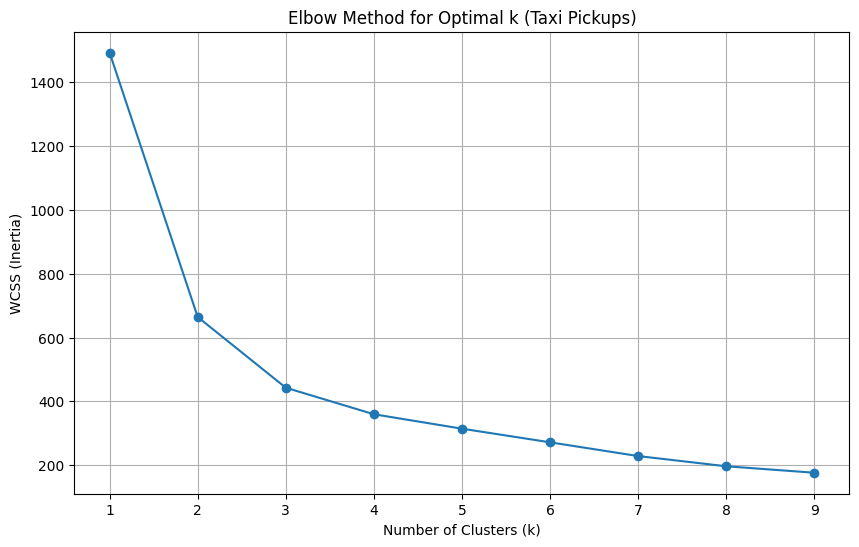

In [11]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster
import gc
import contextily as ctx

# Bounding Box for NYC area
northLatitude = 40.86
southLatitude = 40.68
eastLongitude = -73.92
westLongitude = -74.03

myColumns = ["medallion", "hack_license", "pickup_datetime",
             "dropoff_datetime", "trip_time_in_secs", "trip_distance",
             "pickup_longitude", "pickup_latitude", "dropoff_longitude",
             "dropoff_latitude", "payment_type", "fare_amount",
             "surcharge", "mta_tax", "tip_amount",
             "tolls_amount", "total_amount"]

# Columns we actually need for clustering pickup locations
cols_to_load = ['pickup_longitude', 'pickup_latitude']

# Range of k values to test for the elbow
MAX_K_ELBOW = 10
k_range = range(1, MAX_K_ELBOW)
wcss = [] # List to store Within-Cluster Sum of Squares (Inertia)


dataset_pd_elbow = pd.read_csv(
    Small_dataset,
    names=myColumns,
    usecols=cols_to_load,
    dtype={'pickup_longitude': np.float32, 'pickup_latitude': np.float32}
)

# Filter data within the bounding box and drop any NaN coordinates
filtered_data_pd_elbow = dataset_pd_elbow[
    (dataset_pd_elbow.pickup_longitude >= westLongitude) &
    (dataset_pd_elbow.pickup_longitude <= eastLongitude) &
    (dataset_pd_elbow.pickup_latitude >= southLatitude) &
    (dataset_pd_elbow.pickup_latitude <= northLatitude)
].dropna()

# Compute WCSS if enough points
if len(filtered_data_pd_elbow) >= MAX_K_ELBOW:
    X_pd_elbow = filtered_data_pd_elbow[['pickup_longitude', 'pickup_latitude']].values
    for k in k_range:
        kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_pd_elbow)
        wcss.append(kmeans.inertia_)

    # --- Plotting the Elbow Method graph ---
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, wcss, marker='o', linestyle='-')
    plt.title('Elbow Method for Optimal k (Taxi Pickups)')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS (Inertia)')
    plt.xticks(np.arange(1, MAX_K_ELBOW, step=1)) # Ensure integer ticks
    plt.grid(True)
    plt.show()

In [12]:
# Define Number of clusters (Taxi Ranks)
n_clusters = 4

# Define dataset schema
mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

# --- Helper Function for Plotting Pickup location clusters ---

def plot_clusters_on_map(heatmap_data, library_name, n_clusters,
                         west_lon, east_lon, south_lat, north_lat):
    if heatmap_data is None or heatmap_data.empty:
        print(f"Plotting skipped for {library_name}: No heatmap data.")
        return

    print(f"Plotting results for {library_name}...")
    fig, ax = plt.subplots(figsize=(10, 10))

    # Scale size reasonably
    sizes = np.maximum(heatmap_data['count'] * 0.05, 10)

    # Plot cluster centers
    scatter = ax.scatter(heatmap_data['longitude'], heatmap_data['latitude'],
                         c=heatmap_data['count'], s=sizes,
                         cmap='viridis', alpha=0.8,
                         edgecolor='k', linewidth=0.5)

    # Set limits BEFORE adding basemap
    ax.set_xlim(west_lon, east_lon)
    ax.set_ylim(south_lat, north_lat)

    # Add the basemap (will raise error if tile fetching fails)
    ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

    # Add colorbar
    plt.colorbar(scatter, ax=ax, label='Number of Pickups', shrink=0.7)

    ax.set_title(f'Taxi Rank Locations ({library_name}) - {n_clusters} Clusters')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    plt.tight_layout()
    plt.show()

### Code: Sci-kit learn

Pandas: Loaded 1999999 rows.
Plotting results for scikit-learn...


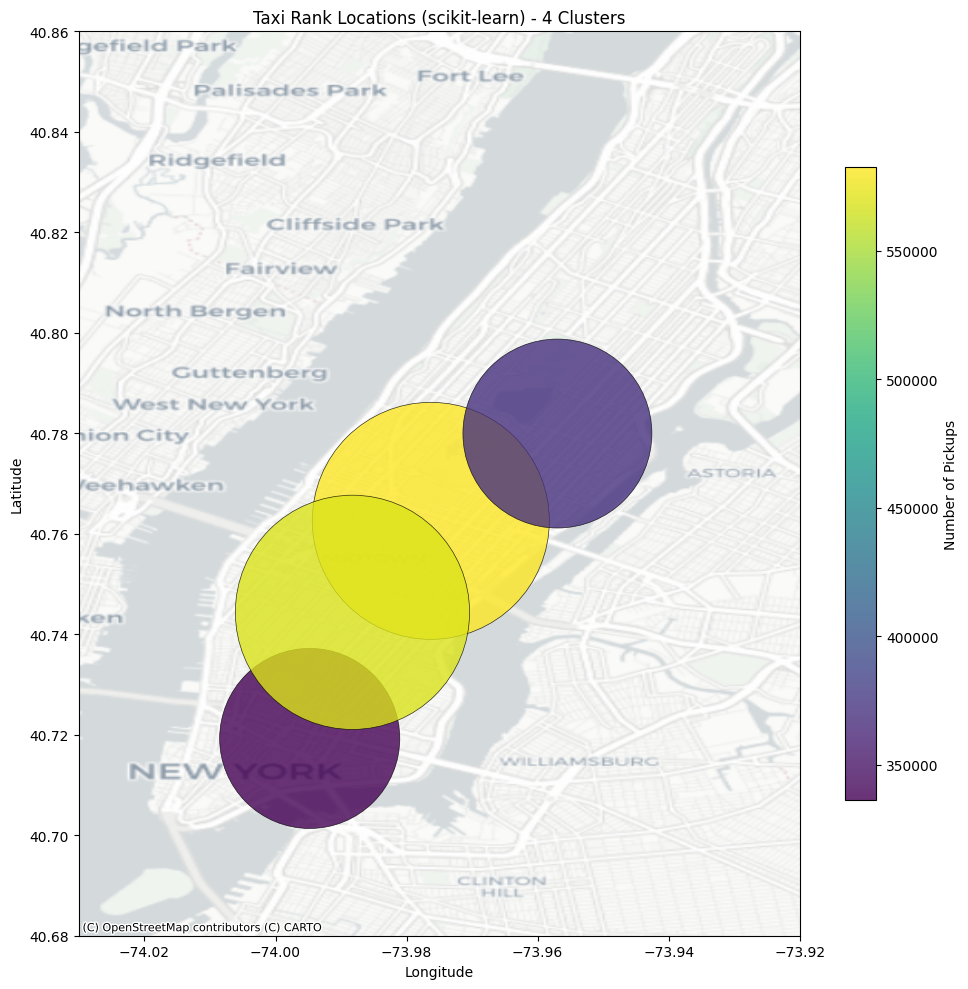

Runtime (scikit-learn) = 27.4282 seconds


In [ ]:
# start time
start_time_sklearn = time.time()

# Load in only necessary columns with Pandas
dataset_pd = pd.read_csv(
    Small_dataset,
    names=myColumns,
    usecols=cols_to_load,
    header=None,
    dtype={'pickup_longitude': np.float32, 'pickup_latitude': np.float32}
)
print(f"Pandas: Loaded {len(dataset_pd)} rows.")

# Filter data within the bounding box and drop NaNs
filtered_data_pd = dataset_pd[
    (dataset_pd.pickup_longitude >= westLongitude) &
    (dataset_pd.pickup_longitude <= eastLongitude) &
    (dataset_pd.pickup_latitude >= southLatitude) &
    (dataset_pd.pickup_latitude <= northLatitude)
].dropna()


heatmap_data_sklearn = None # Initialize for plotting check

# Perform K-means clustering
X_pd = filtered_data_pd[['pickup_longitude', 'pickup_latitude']].values
kmeans_sklearn = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_sklearn.fit(X_pd)
centers_sklearn = kmeans_sklearn.cluster_centers_
labels_sklearn = kmeans_sklearn.labels_
cluster_counts_sklearn = np.bincount(labels_sklearn, minlength=n_clusters)

# Save results in Dataframe for creating heatmap
heatmap_data_sklearn = pd.DataFrame({
    'longitude': centers_sklearn[:, 0],
    'latitude': centers_sklearn[:, 1],
    'count': cluster_counts_sklearn
})

# Create heatmap
plot_clusters_on_map(heatmap_data_sklearn, 'scikit-learn', n_clusters,
                     westLongitude, eastLongitude, southLatitude, northLatitude)

end_time_sklearn = time.time()
time_sklearn = end_time_sklearn - start_time_sklearn
print(f"Runtime (scikit-learn) = {time_sklearn:.4f} seconds")

### Results (Sci-kit)

The time to process the was: **27.4282 seconds**

The clusters have significant overlap. Of the 4 clusters, there are two bigger ones in terms of area and # pickups (> 500 000 pickups each) in the center of New York City, and two smaller ones in terms of area and # pickups (ca. 350 000 pickups) on the outside.

### Code: cuML

Plotting results for cuML...


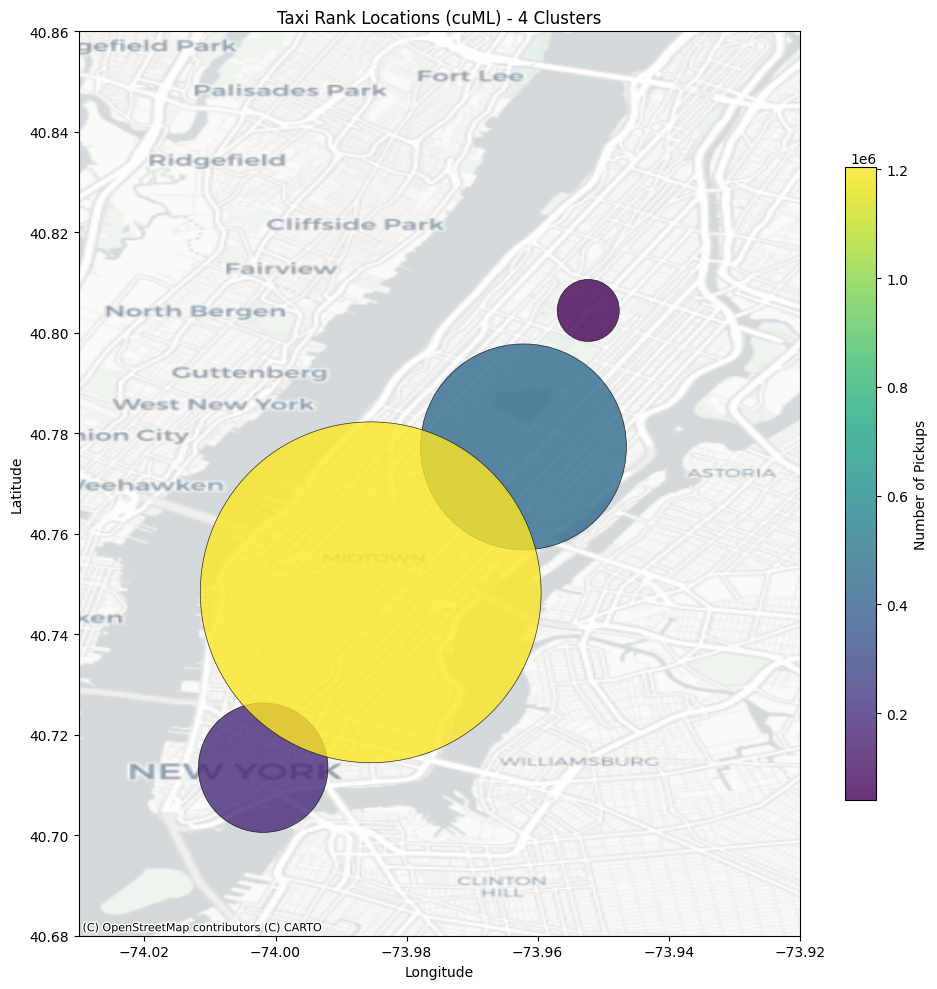

Runtime (cuML) = 6.0850 seconds


In [ ]:
# Note: Verify we have access to a CUDA-capable GPU to use CuDF and
# Set and validate that CuDF can use the CUDA-capable GPU again using
# first two code cells in Ex. 1 Code: cuDF part of the notebook

start_time_cuml = time.time()  # Records the start time for execution

# Load in Small dataset
dataset_cudf = cudf.read_csv(    # Reads the dataset using cuDF (GPU DataFrame library)
    Small_dataset,              # Path to the small dataset
    names=myColumns,            # Column names
    usecols=cols_to_load,       # Selects only the needed columns: 'pickup_longitude', 'pickup_latitude'
    header=None,                 # Specifies that there's no header row in the data
    dtype={'pickup_longitude': 'float32', 'pickup_latitude': 'float32'} # Sets data types for efficiency
)

# Filter drop-offs and pickups to only those within the bounding box and drop NaNs
filtered_data_cudf = dataset_cudf[
    (dataset_cudf.pickup_longitude >= westLongitude) &
    (dataset_cudf.pickup_longitude <= eastLongitude) &
    (dataset_cudf.pickup_latitude >= southLatitude) &
    (dataset_cudf.pickup_latitude <= northLatitude)
].dropna()

# Initialize empty element to create Dataframe from later
heatmap_data_cuml = None

# Perform K-means clustering
X_cudf = filtered_data_cudf[['pickup_longitude', 'pickup_latitude']] #
kmeans_cuml = cuml.cluster.KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # Creates KMeans object
kmeans_cuml.fit(X_cudf) # Performs k-means clustering
centers_cuml_host = kmeans_cuml.cluster_centers_.to_numpy() # Extracts cluster centers as NumPy array
labels_cuml_host = kmeans_cuml.labels_.to_numpy() # Extracts cluster labels for each data point
cluster_counts_cuml = np.bincount(labels_cuml_host, minlength=n_clusters) # Counts pickups per cluster

# Save results in Dataframe for creating heatmap
heatmap_data_cuml = pd.DataFrame({
    'longitude': centers_cuml_host[:, 0],
    'latitude': centers_cuml_host[:, 1],
    'count': cluster_counts_cuml
})

# Create heatmap
plot_clusters_on_map(heatmap_data_cuml, 'cuML', n_clusters,
                     westLongitude, eastLongitude, southLatitude, northLatitude)

end_time_cuml = time.time()
time_cuml = end_time_cuml - start_time_cuml

print(f"Runtime (cuML) = {time_cuml:.4f} seconds")

### Results (cuML)

The time to process the was: **6.0850 seconds**

The clusters have less overlap than those of sci-kit learn. There is a very big cluster in terms of area and # pickups (1.2 million pickups) in the center of New York City closer to the tip , a medium sized cluster in the center but further away from the tip (ca. 500 000 pickups) and two small clusters on the outside of the city (>300 000 pickups)

### Code: Spark MLib

Plotting results for Spark MLlib...


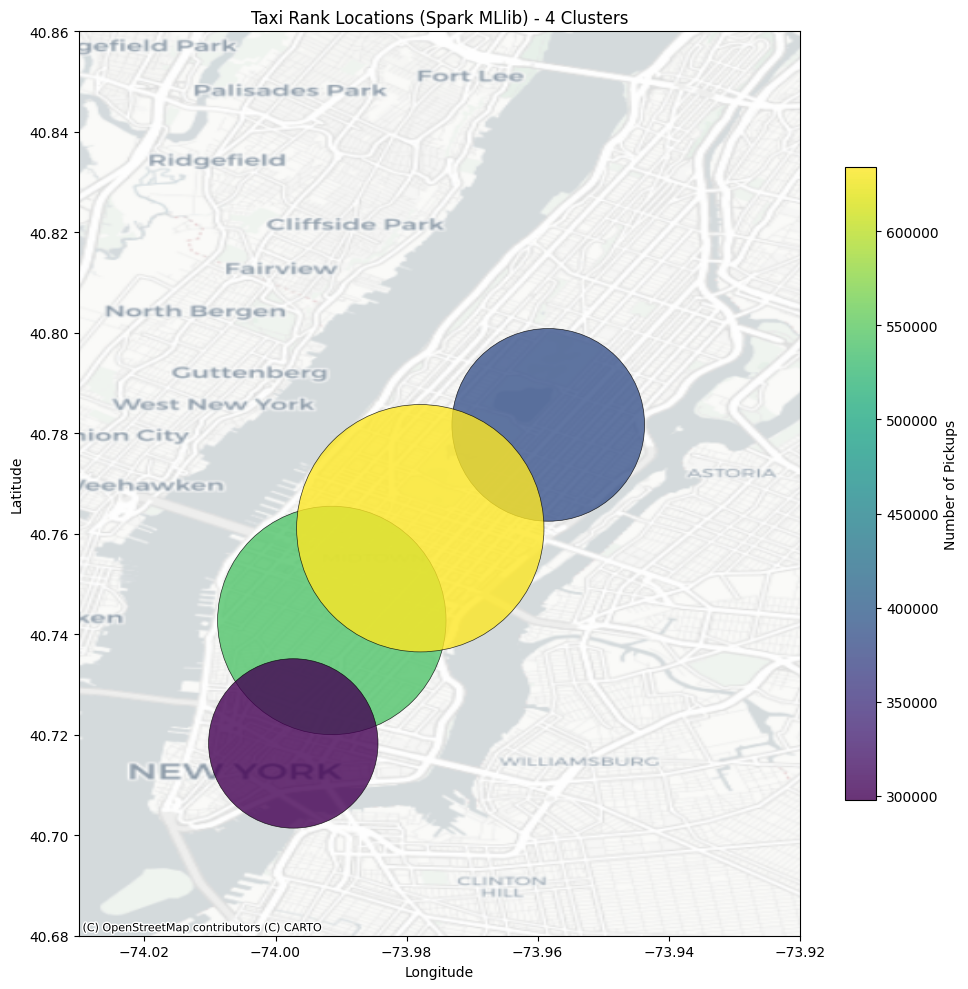

Runtime (Spark MLlib) = 73.0184 seconds


In [ ]:
# Create Spark Session
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()


start_time_spark = time.time()

# Load in dataset with Spark
dataset_spark = spark.read.load(
    Small_dataset,
    format="csv",
    sep=",",
    schema=mySchema,
    header="false"
)

# Filter data, select columns, drop NaNs
filtered_data_spark = dataset_spark.select("pickup_longitude", "pickup_latitude").filter(
    (col("pickup_longitude") >= westLongitude) &
    (col("pickup_longitude") <= eastLongitude) &
    (col("pickup_latitude") >= southLatitude) &
    (col("pickup_latitude") <= northLatitude)
).dropna()


count_in_box = filtered_data_spark.count()

heatmap_data_spark = None # Initialize for plotting check
features_spark = None # Initialize to check for unpersist
if count_in_box >= n_clusters:
    vector_assembler = VectorAssembler(
        inputCols=["pickup_longitude", "pickup_latitude"],
        outputCol="features",
        handleInvalid="skip"
    )
    features_spark = vector_assembler.transform(filtered_data_spark).select("features")
    features_spark.cache()
    feature_count = features_spark.count() # Trigger cache and check count

    # Perform K-means clustering
    if feature_count >= n_clusters:
        kmeans_spark = KMeans(k=n_clusters, seed=42, featuresCol="features", predictionCol="prediction")
        model_spark = kmeans_spark.fit(features_spark)
        centers_spark = np.array(model_spark.clusterCenters())
        predictions_spark = model_spark.transform(features_spark)
        cluster_counts_df_spark = predictions_spark.groupBy("prediction").count()
        cluster_counts_list_spark = cluster_counts_df_spark.collect()
        counts_spark = np.zeros(n_clusters, dtype=int)
        for row in cluster_counts_list_spark:
            if 0 <= row["prediction"] < n_clusters:
                counts_spark[row["prediction"]] = row["count"]

        # Save results in Dataframe for creating heatmap
        heatmap_data_spark = pd.DataFrame({
            'longitude': centers_spark[:, 0],
            'latitude': centers_spark[:, 1],
            'count': counts_spark
        })

        # Create heatmap
        plot_clusters_on_map(heatmap_data_spark, 'Spark MLlib', n_clusters,
                             westLongitude, eastLongitude, southLatitude, northLatitude)

    # Unpersist cached data if it was created
    if features_spark:
        features_spark.unpersist()


end_time_spark = time.time()
time_spark = end_time_spark - start_time_spark
print(f"Runtime (Spark MLlib) = {time_spark:.4f} seconds")

### Results (Spark)

The time to process the was: **73.0184 seconds**

There is again significant overlap of the clusters. The clusters are, however, clearest to identify in terms of the # of pickups. The largest cluster is in the center away from the tip with >600 000 pickups. The second largest cluster is also in the center but closer to the tip and has around 500 000 pickups. The cluster furthest from the tip has around 400 000 pickups, while the one closest to the tip has around 300 000 pickups.

### Execution Times (All Three methods)

scikit-learn: **27.4282 seconds**

cuML: **6.8577 seconds**

Spark Mlib: **73.0184 seconds**


### Discussion of results

**COMPLETE: Explain the rationale of your solution, your code and discuss results**

**Rationale**: The goal is to identify optimal taxi rank locations in NYC by clustering pickup coordinates, minimizing walking distance for clients. K-means clustering is used to group pickups into clusters, with cluster centers as taxi ranks. The Elbow Method suggests 3–4 clusters, and 4 clusters are chosen to balance coverage and granularity in NYC.

**Code Explanation**:
- **Elbow Method (Scikit-learn)**: Loads the small dataset with Pandas, filters pickups within the NYC bounding box, and computes the Within-Cluster Sum of Squares (WCSS) for k=1 to 10 using (`sklearn.cluster.KMeans`). The WCSS is plotted to identify the "elbow" point, indicating optimal k (3–4 clusters).
- **Common Setup**: Defines the NYC bounding box and schema. A plotting function (`plot_clusters_on_map`) visualizes cluster centers on a map, with marker size and color based on pickup counts.
- **Scikit-learn**: Loads data with Pandas, filters within the NYC box, and applies K-means (`sklearn.cluster.KMeans`) with 4 clusters.
- **cuML**: Uses cuDF for GPU-accelerated data loading and filtering, applies `cuml.cluster.KMeans`.
- **Spark MLib**: Loads data with Spark, filters, assembles features with `VectorAssembler`, and applies `KMeans`. Runtime: **73.02 seconds**.

**Results Discussion**:
- **Performance**: cuML took **6.86 seconds**, Scikit-learn took **27.43 seconds**, Spark MLlib **73.02 seconds**. Spark MLlib’s longer runtime reflects distributed overhead, while scikit-learn benefits from single-threaded efficiency on the small dataset. cuML is the fastest because it leverages the GPU for parallelized processing.
- **Cluster Quality**: All three libraries produced different clusters. We can proxy the quality of the clusters (high cohesion and high separation) by looking at how overlapping the clusters are for each of the three libraries.
  - **Scikit-learn**: The clusters have significant overlap.
  - **cuML**: The clusters have the least overlap.
  - **Spark MLib**: There is again significant overlap of the clusters.
  Therefore, it seems that **cuML produced the highest quality clusters**. This would make sense as well as cuML and sci-kit learn by default will run several random initializations of the K-means clustering in parallel, choosing the best one at the end. Spark MLib on the other hand does not produce many independent runs because co-ordinating full runs over an entire cluster adds significant overhead.

  However, a caveat is that we did not set the random initialization of the clusters to be the same for all three frameworks, so it cannot be ruled out that a better random initialization also lead cuML to perform better than the other frameworks.

  Finally, 4 clusters may also be too few for comprehensive coverage, as some areas (e.g., northern Manhattan) lack coverage.
- **Framework Suitability**:
  - **Scikit-learn**: Suitable for small datasets, fast on CPUs, but scales poorly for larger data.
  - **cuML**: Best for speed with GPUs.
  - **Spark MLlib**: Ideal for scalability on large datasets, but overhead makes it less efficient for small data.
- **Preference**: cuML is preferrable due to its speed. If no GPU is available, Scikit-learn is second best for this task due to its balance of speed and reliability on the small dataset. For larger datasets, Spark MLlib or cuML would be better. Increasing clusters (e.g., to 10–20) could improve coverage.